In [1]:
import numpy as np
from PIL import Image, ImageFilter, ImageOps, ImageDraw
import matplotlib.pyplot as plt
import random
from torchvision import transforms
import glob
import os
import operator
from scipy.spatial import ConvexHull

/home/ubuntu/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Functions

In [2]:
class Deformer:
    def __init__(self, imsize:tuple, points:tuple) -> None:
        self.imsize = imsize
        self.crop_left, self.crop_top,self.crop_right, self.crop_bottom = points
        
    def getmesh(self, img):
        return [(
                # target rectangle
                (self.crop_left, self.crop_top,self.crop_right, self.crop_bottom),
                # corresponding source quadrilateral
                (np.random.randint(0, self.imsize[0]), 
                 np.random.randint(0,self.imsize[0]),
                 np.random.randint(0,self.imsize[0]),
                 np.random.randint(0,self.imsize[0]),
                 np.random.randint(0,self.imsize[1]),
                 np.random.randint(0,self.imsize[1]),
                 np.random.randint(0,self.imsize[1]),
                 np.random.randint(0,self.imsize[1]))
                )]


def generate_rotations(image:Image):
  r90 = image.rotate(90)
  r180 = image.rotate(180)
  r270 = image.rotate(270)
  return image, r90, r180, r270


def normalize_in_interval(sample_mat, interval_min, interval_max):
    x =(sample_mat - np.min(sample_mat)) / (np.max(sample_mat) - np.min(sample_mat)) * (interval_max - interval_min) + interval_min
    x = np.rint(x)
    return x


def paste_patch(image, patch, coords, mask = None):
  aug_image = image.copy()
  aug_image.paste(patch, (coords[0], coords[1]), mask=mask)
  return aug_image


def apply_patch_augmentations(patch:Image, 
                              augmentations:transforms.ColorJitter=None):
  #patch = patch.filter(ImageFilter.GaussianBlur(random.randint(0, 2)))
  return augmentations(patch)


def random_color():
  return random.randint(10,240)


def generate_scar(image:Image, 
                  w_range=(8,32), 
                  h_range=(20,50),
                  augs=None):
  img_w, img_h = image.size
  #right = 1
  #left = 1
  #top = 1
  #bottom = 1
  #dimensioni sezione
  scar_w = random.randint(w_range[0], w_range[1])
  scar_h = random.randint(h_range[0], h_range[1])

  #new_width = scar_w + right + left
  #new_height = scar_h + top + bottom
  r = random_color()
  g = random_color()
  b = random_color()

  #color = (r,g,b)
  patch_left, patch_top = random.randint(0, img_w - scar_w), random.randint(0, img_h - scar_h)
  patch_right, patch_bottom = patch_left + scar_w, patch_top + scar_h

  #scar = Image.new('RGBA', (scar_w, scar_h), color=color)
  scar = image.crop((patch_left, patch_top, patch_right, patch_bottom))
  #scar_with_pad = Image.new(image.mode, (new_width, new_height), (255, 255, 255))
  
  mask = Image.new('RGBA', (scar_w, scar_h), (255,255,255,0)) 
  draw = ImageDraw.Draw(mask)
  points = 0.1 + 0.8*np.random.rand(random.randint(3,15), 2)
  x = [points[i][0] for i in range(len(points))]
  y = [points[i][1] for i in range(len(points))]
  x1 = normalize_in_interval(x, 0, mask.size[0])
  y1 = normalize_in_interval(y, 0, mask.size[1])
  points = [(x1[i], y1[i]) for i in range(len(points))]
  draw.polygon(points, fill='black')
  
  scar = apply_patch_augmentations(scar, augs)
  #scar_with_pad.paste(scar, (left, top))
  scar = scar.convert('RGBA')
  angle = random.randint(-45, 45)
  scar = scar.rotate(angle, expand=True)
  
  mask = mask.rotate(angle, expand=True)

  #posizione casuale della sezione
  left, top = random.randint(0, img_w - scar_w), random.randint(0, img_h - scar_h)
  return scar, mask, (left, top)


def get_random_points(org_w, org_h, num_points=3):
    points = []
    for i in range(num_points):
        points.append((random.randint(0, org_w), random.randint(0, org_h)))
    return points


def generate_patch(
        image, 
        area_ratio:tuple=(0.02, 0.15), 
        aspect_ratio:tuple=((0.3, 1),(1, 3.3)),
        polygoned=False,
        distortion=False):

    img_area = image.size[0] * image.size[1]
    patch_area = random.uniform(area_ratio[0], area_ratio[1]) * img_area
    patch_aspect = random.choice([random.uniform(*aspect_ratio[0]), random.uniform(*aspect_ratio[1])])
    patch_w  = int(np.sqrt(patch_area*patch_aspect))
    patch_h = int(np.sqrt(patch_area/patch_aspect))
    org_w, org_h = image.size

    patch_left, patch_top = random.randint(0, org_w - patch_w), random.randint(0, org_h - patch_h)
    patch_right, patch_bottom = patch_left + patch_w, patch_top + patch_h
    paste_left, paste_top = random.randint(0, org_w - patch_w), random.randint(0, org_h - patch_h)

    mask = None
    
    if polygoned:
        mask = Image.new('RGBA', (patch_w, patch_h), (255,255,255,0)) 
        draw = ImageDraw.Draw(mask)
            
        raw_points = 0.1 + 0.8*np.random.rand(random.randint(3,15), 2)
        ch = ConvexHull(raw_points)
        hull_indices = ch.vertices
        points = raw_points[hull_indices, :]
        x = [points[i][0] for i in range(len(points))]
        y = [points[i][1] for i in range(len(points))]
        x1 = normalize_in_interval(x, 0, mask.size[0])
        y1 = normalize_in_interval(y, 0, mask.size[1])
        points = [(x1[i], y1[i]) for i in range(len(points))]
        draw.polygon(points, fill='black')
        
    if distortion:
        deformer = Deformer(imsize=image.size, points=(patch_left, patch_top, patch_right, patch_bottom))
        deformed_image = ImageOps.deform(image, deformer)
        cropped_patch = deformed_image.crop((patch_left, patch_top, patch_right, patch_bottom))
    else:
        cropped_patch = image.crop((patch_left, patch_top, patch_right, patch_bottom))
    return cropped_patch, mask, (paste_left, paste_top)


def get_impaths(main_path):
  return sorted([f for f in glob.glob(main_path+'*.png', recursive = True)])


def load_imgs(main_path, imsize):
  filenames = get_impaths(main_path)
  images = []
  for impath in filenames:
    x = Image.open(impath)
    x = x.resize(imsize)
    images.append(x)
  return images


def show_examples(subject, 
                  colojitter_offset=0.1,
                  area_ratio=(0.02, 0.15), 
                  aspect_ratio=((0.3, 1),(1, 3.3)),
                  scar_width=(2,16), 
                  scar_thiccness=(10,25),
                  figsize=(16,16),
                  seed=0,
                  polygoned=True,
                  distorted=False):
  random.seed(seed)
  np.random.seed(seed)
  
  imsize=(256,256)
  good0 = Image.open("../dataset/"+subject+"/train/good/000.png").resize(imsize).convert('RGB')
  good1 = Image.open("../dataset/"+subject+"/train/good/001.png").resize(imsize).convert('RGB')
  good2 = Image.open("../dataset/"+subject+"/train/good/002.png").resize(imsize).convert('RGB')
  good3 = Image.open("../dataset/"+subject+"/train/good/003.png").resize(imsize).convert('RGB')
  good4 = Image.open("../dataset/"+subject+"/train/good/004.png").resize(imsize).convert('RGB')
  good5 = Image.open("../dataset/"+subject+"/train/good/005.png").resize(imsize).convert('RGB')
  good6 = Image.open("../dataset/"+subject+"/train/good/006.png").resize(imsize).convert('RGB')
  good7 = Image.open("../dataset/"+subject+"/train/good/007.png").resize(imsize).convert('RGB')

  gb_examples = [good0, good1, good2, good3, good4, good5]
    
    
  augs = transforms.ColorJitter(brightness = colojitter_offset,
                                  contrast = colojitter_offset,
                                  saturation = colojitter_offset,
                                  hue = colojitter_offset)

  hseparator = Image.new(mode='RGB', size=(6,256), color=(255,255,255))
  good_images = np.hstack([np.hstack(
      [np.array(gb_examples[i]), np.array(hseparator)]
      ) if i < len(gb_examples)-1 else np.array(gb_examples[i]) for i in range(len(gb_examples))])    
  aaa = []
  for i in range(len(gb_examples)):
      mask = None
      patch, mask, coords = generate_patch(
              image=gb_examples[i], 
              area_ratio=area_ratio, 
              aspect_ratio=aspect_ratio, 
              polygoned=polygoned, 
              distortion=distorted)
      patch = apply_patch_augmentations(patch, augs)
      aug_im = paste_patch(gb_examples[i], patch, coords, mask)
      aaa.append(aug_im)
  cutpaste_images = np.hstack([np.hstack(
      [np.array(aaa[i]), np.array(hseparator)]
      ) if i < len(aaa)-1 else np.array(aaa[i]) for i in range(len(aaa))])  
  bbb = []
  for i in range(len(gb_examples)):
      scar, mask, coords = generate_scar(gb_examples[i],
                                  w_range=scar_width,
                                  h_range=scar_thiccness,
                                  augs=augs)
      
      #scar, coords = generate_polygoned_scar(gb_examples[i], w_range=scar_width,h_range=scar_thiccness)
      scar_im = paste_patch(gb_examples[i], scar, coords, mask)
      #scar_im = deform_image(gb_examples[i])
      bbb.append(scar_im)
  scar_images = np.hstack([np.hstack(
      [np.array(bbb[i]), np.array(hseparator)]
      ) if i < len(bbb)-1 else np.array(bbb[i]) for i in range(len(bbb))])
  
  vseparator = np.array(Image.new(
      mode='RGB', 
      size=((256*len(bbb))+(6*(len(bbb)-1)), 6), 
      color=(255,255,255)))
  
  tot = np.vstack([
      np.vstack([good_images, vseparator]), 
      np.vstack([cutpaste_images, vseparator]), 
      scar_images])
  if not os.path.exists('../temp/dataset_analysis/'+subject+'/'):
      os.makedirs('../temp/dataset_analysis/'+subject+'/')
  plt.figure(figsize=figsize)
  plt.axis('off')
  plt.imshow(tot)
  plt.savefig('../temp/dataset_analysis/'+subject+'/'+subject+'_artificial.png', bbox_inches='tight')

### Visualization

Testing the cutpaste augmentation functions on mvtec objects

In [3]:
colojitter_offset=0.3
area_ratio=(0.02, 0.15)
aspect_ratio=((0.3, 1),(1, 6.6))
scar_width=(2,16)
scar_thiccness=(10,25)
figsize=(12,12)

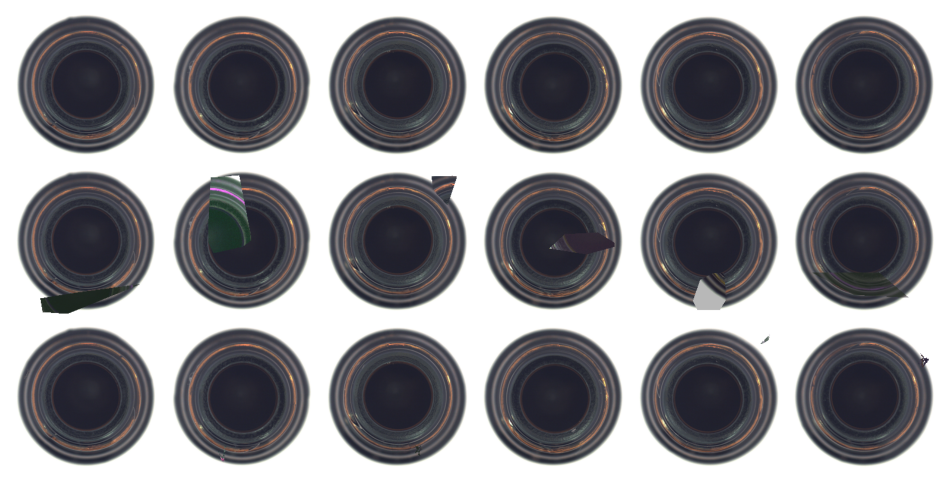

In [4]:
show_examples(
    'bottle',
    colojitter_offset=colojitter_offset,
    area_ratio=area_ratio, 
    aspect_ratio=aspect_ratio,
    scar_width=scar_width, 
    scar_thiccness=scar_thiccness,
    figsize=figsize
)

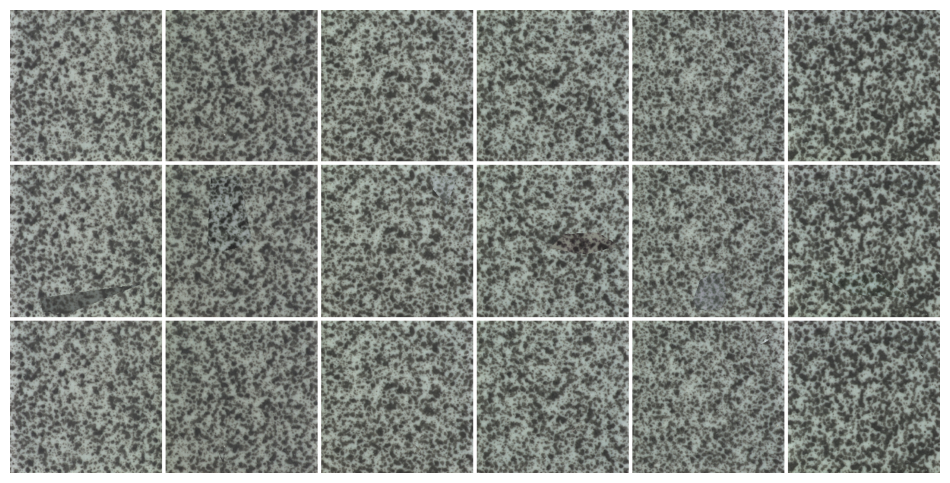

In [5]:
show_examples(
    'tile',
    colojitter_offset=colojitter_offset,
    area_ratio=area_ratio, 
    aspect_ratio=aspect_ratio,
    scar_width=scar_width, 
    scar_thiccness=scar_thiccness,
    figsize=figsize
)

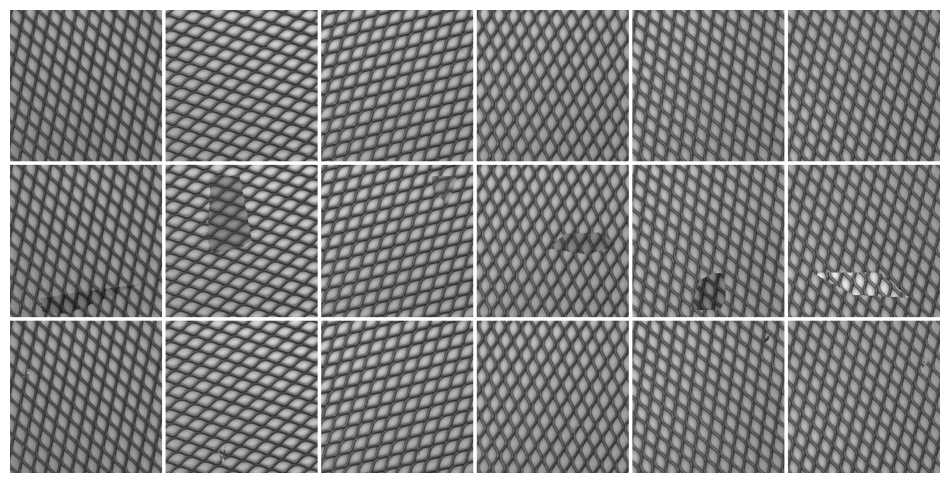

In [6]:
show_examples(
    'grid',
    colojitter_offset=colojitter_offset,
    area_ratio=area_ratio, 
    aspect_ratio=aspect_ratio,
    scar_width=scar_width, 
    scar_thiccness=scar_thiccness,
    figsize=figsize
)

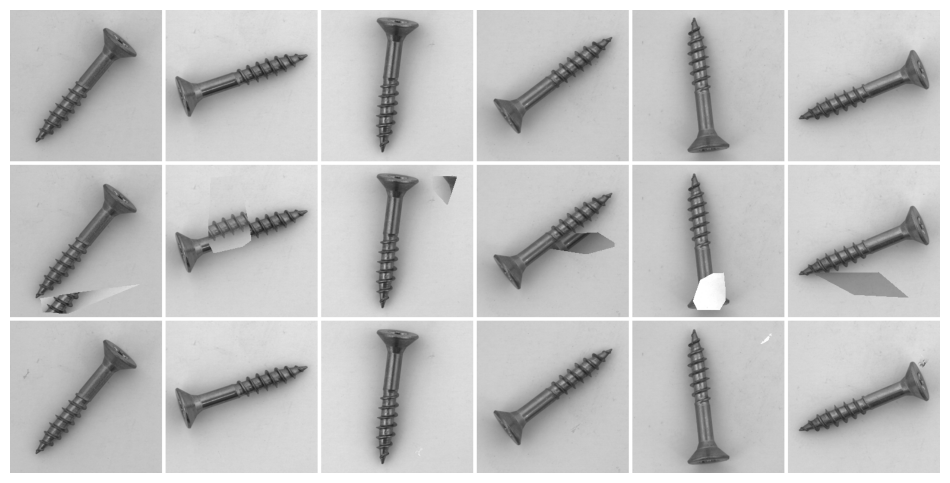

In [7]:
show_examples(
    'screw',
    colojitter_offset=colojitter_offset,
    area_ratio=area_ratio, 
    aspect_ratio=aspect_ratio,
    scar_width=scar_width, 
    scar_thiccness=scar_thiccness,
    figsize=figsize
)

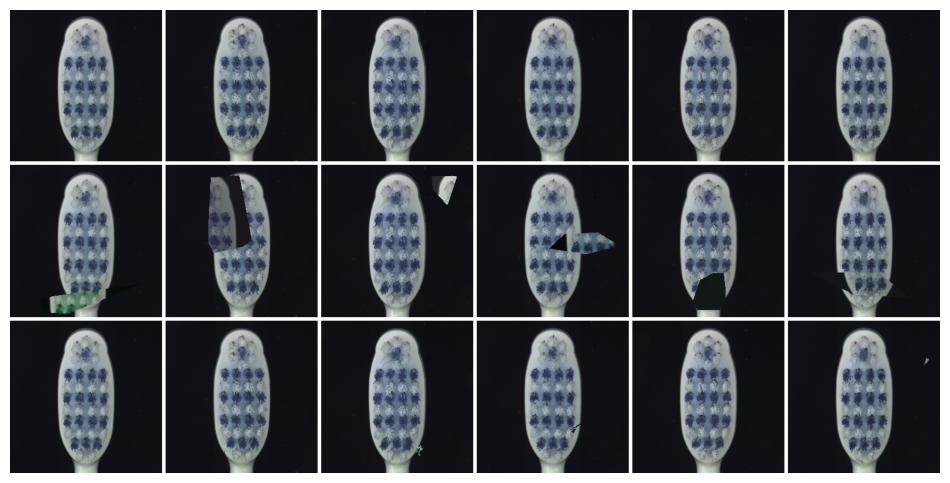

In [8]:
show_examples(
    'toothbrush',
    colojitter_offset=colojitter_offset,
    area_ratio=area_ratio, 
    aspect_ratio=aspect_ratio,
    scar_width=scar_width, 
    scar_thiccness=scar_thiccness,
    figsize=figsize
)

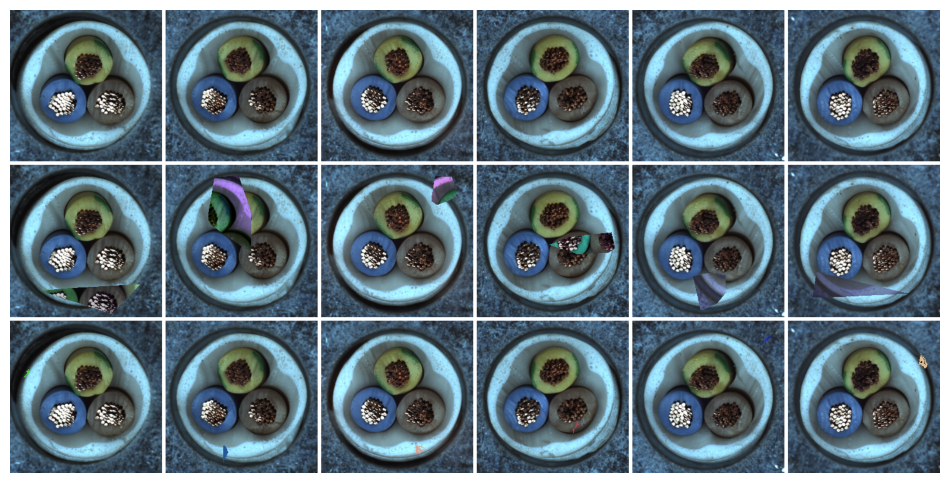

In [22]:
show_examples(
    'cable',
    colojitter_offset=colojitter_offset,
    area_ratio=area_ratio, 
    aspect_ratio=aspect_ratio,
    scar_width=scar_width, 
    scar_thiccness=scar_thiccness,
    figsize=figsize
)

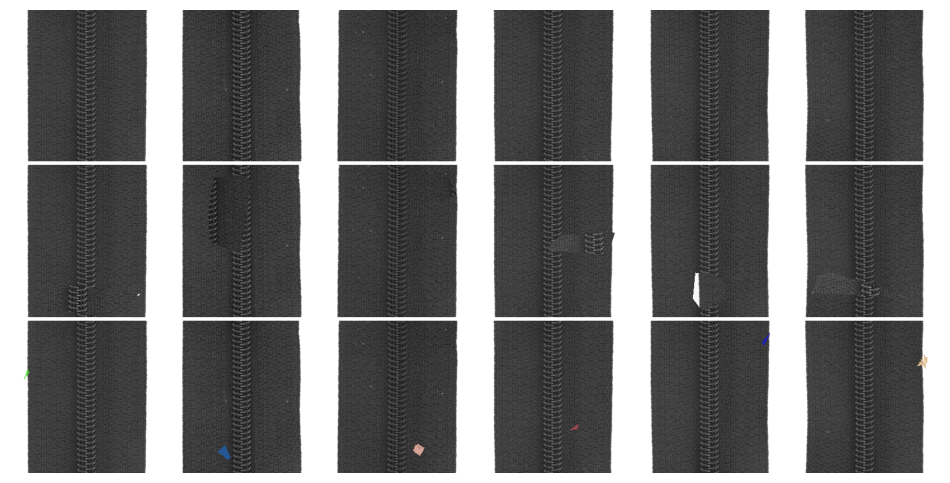

In [23]:
show_examples(
    'zipper',
    colojitter_offset=colojitter_offset,
    area_ratio=area_ratio, 
    aspect_ratio=aspect_ratio,
    scar_width=scar_width, 
    scar_thiccness=scar_thiccness,
    figsize=figsize
)

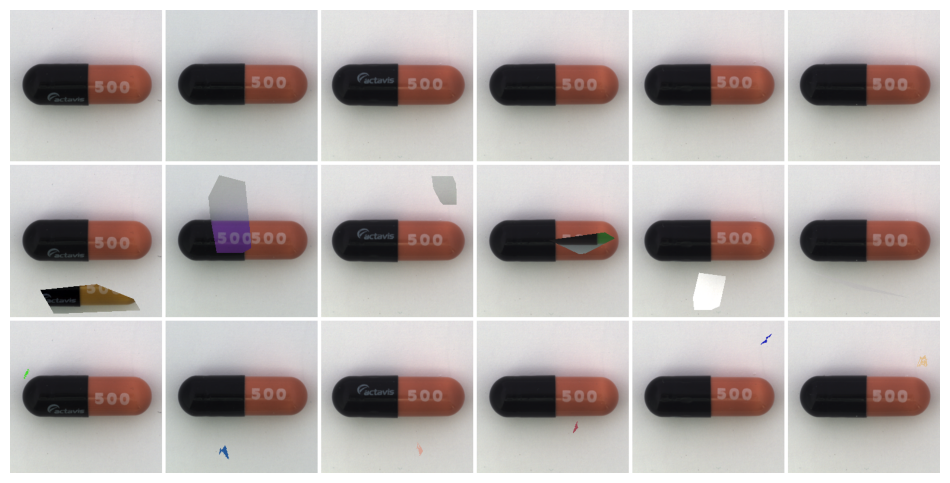

In [24]:
show_examples(
    'capsule',
    colojitter_offset=colojitter_offset,
    area_ratio=area_ratio, 
    aspect_ratio=aspect_ratio,
    scar_width=scar_width, 
    scar_thiccness=scar_thiccness,
    figsize=figsize
)